In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer


# READ DF + NORMALIZE

In [2]:
df = pd.read_csv("merged_data.csv")
df

,X,Y,Z,EDA,HR,TEMP
0,-13,-61,5,6.769995,99.43,31.17
1,-20,-69,-3,6.769995,99.43,31.17
2,-31,-78,-15,6.769995,99.43,31.17
3,-47,-65,-38,6.769995,99.43,31.17
4,-67,-57,-53,6.769995,99.43,31.17
...,...,...,...,...,...,...
1995,-15,57,27,5.896443,85.75,31.61
1996,-14,56,31,5.896443,85.75,31.61
1997,-11,56,30,5.896443,85.75,31.61
1998,-9,58,26,5.896443,85.75,31.61


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       2000 non-null   int64  
 1   Y       2000 non-null   int64  
 2   Z       2000 non-null   int64  
 3   EDA     2000 non-null   float64
 4   HR      2000 non-null   float64
 5   TEMP    2000 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 93.9 KB


In [4]:
quantile_trans = QuantileTransformer(n_quantiles=df.shape[0], output_distribution='normal')
df_scaled = pd.DataFrame(quantile_trans.fit_transform(df), columns=df.columns)
df_scaled

,X,Y,Z,EDA,HR,TEMP
0,0.230879,-2.131882,-1.753363,1.687300,-0.009405,-5.199338
1,-0.136475,-2.307796,-1.873274,1.687300,-0.009405,-5.199338
2,-1.114342,-2.673620,-2.063981,1.687300,-0.009405,-5.199338
3,-1.420103,-2.190138,-2.840644,1.687300,-0.009405,-5.199338
4,-2.156874,-2.096724,-5.199338,1.687300,-0.009405,-5.199338
...,...,...,...,...,...,...
1995,0.116882,0.765923,-0.052690,-0.322104,-5.199338,5.199338
1996,0.163741,0.447759,0.752541,-0.322104,-5.199338,5.199338
1997,0.571318,0.447759,0.592857,-0.322104,-5.199338,5.199338
1998,0.950869,1.418386,-0.489748,-0.322104,-5.199338,5.199338


# K-MEANS-LTS

In [5]:
# Return K_MEANS dengan cluster_id dan distance to centroid
def cluster_maker(dataframe, n_cluster_lts):
    kmeans = KMeans(n_clusters=n_cluster_lts, init='k-means++', random_state=42).fit(dataframe)

    dataframe['distance_to_centroid'] = np.min(kmeans.transform(dataframe), axis=1)
    dataframe['cluster_id'] = kmeans.labels_

    return dataframe

In [6]:
# Memisahkan dataframe & mengurutkan berdasarkan distance
def separate_dataframe(dataframe, n_cluster_lts, sort_column='distance_to_centroid'):
    cluster_dfs = {}

    for i in range(n_cluster_lts):
        cluster_dfs[i] = [dataframe[dataframe['cluster_id'] == i]]
        cluster_dfs[i][0] = cluster_dfs[i][0].sort_values(sort_column, ascending=False)
        
    return cluster_dfs

In [7]:
def KMeans_LTS(df, n_cluster_lts, n_percent):
    clustered_df = cluster_maker(df, n_cluster_lts)
    cluster_dict = separate_dataframe(clustered_df, n_cluster_lts)
    inliers_dfs = []
    outliers_dfs = []

    for cluster_id, df_list in cluster_dict.items():
        # Mengurutkan DataFrame berdasarkan distance_to_centroid secara descending
        sorted_df = df_list[0].sort_values(by='distance_to_centroid', ascending=False)

        # Menghitung jumlah baris yang akan di-trim
        n_rows_to_trim = int(n_percent / 100 * len(sorted_df))

        # Memisahkan inliers dan outliers
        inliers_df = sorted_df.iloc[n_rows_to_trim:]
        outliers_df = sorted_df.iloc[:n_rows_to_trim]

        # Menambahkan cluster_id-out ke outliers
        outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'

        # Menyimpan DataFrame inliers dan outliers
        inliers_dfs.append(inliers_df)
        outliers_dfs.append(outliers_df)

    # Menggabungkan DataFrame inliers dari semua cluster sesuai dengan index awal
    inliers_result = pd.concat(inliers_dfs).drop(columns=['distance_to_centroid']).sort_index()

    # Menggabungkan DataFrame outliers dari semua cluster
    outliers_result = pd.concat(outliers_dfs).drop(columns=['distance_to_centroid']).sort_index()

    # Return hasil clustering inliers+outliers sesuai dengan index awal
    optimal_cluster = pd.concat([inliers_result, outliers_result], axis=0).sort_index()

    return inliers_result, optimal_cluster

# TEST K-MEANS LTS ALGORITHM with K = 7 and n_percentage = 10

C:\Users\Asus\AppData\Local\Temp\ipykernel_19924\951060904.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: 
The palette list has fewer values (7) than needed (14) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: 
The palette list has fewer values (7) than needed (14) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
c:\Users\Asus\AppData\Local\Programs\Pyt

<Figure size 800x800 with 0 Axes>

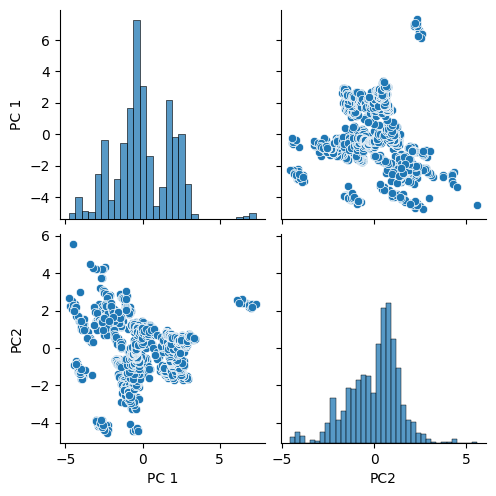

<Figure size 800x800 with 0 Axes>

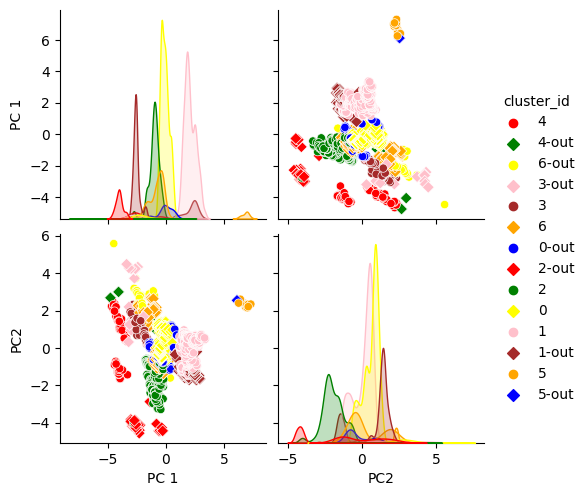

<Figure size 800x800 with 0 Axes>

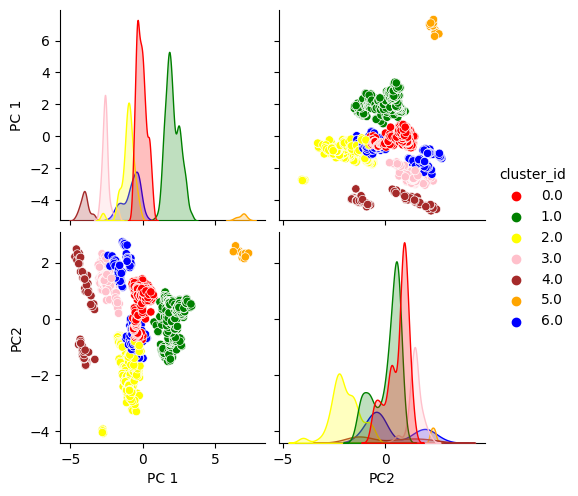

In [8]:
# TEST VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

# GET inliers (LTS_result_filtered) and optimal cluster (LTS_result)
test_df = df_scaled.copy()
LTS_result_filtered, LTS_result = KMeans_LTS(test_df, 7, 10)

# PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = LTS_result.loc[:, LTS_result.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"], palette=['red', 'green', 'yellow', 'pink', 'brown', 'orange', 'blue'])

#PAIR PLOT without OUTLIERS
df_pca['cluster_id'] = LTS_result_filtered.loc[:, LTS_result_filtered.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', palette=['red', 'green', 'yellow', 'pink', 'brown', 'orange', 'blue'])

In [9]:
# FIND SILHOUETTE SCORE
from sklearn.metrics import silhouette_score

inliers_no_id = LTS_result_filtered.drop(['cluster_id'], axis=1)
score = silhouette_score(inliers_no_id, LTS_result_filtered['cluster_id'])
print(score)

0.48386270028624656


In [10]:
# Davies Bouldin Score

from sklearn.metrics import davies_bouldin_score

inliers_no_id = LTS_result_filtered.drop(['cluster_id'], axis=1)
score = davies_bouldin_score(inliers_no_id, LTS_result_filtered['cluster_id'])
print(score)

0.7819883956008563


In [11]:
# FIND SILHOUETTE SCORE untuk HASIL CLUSTER dari INLIERS saja
inliers_cluster = KMeans(n_clusters=7, init='k-means++', random_state=42).fit(inliers_no_id)
score = silhouette_score(inliers_no_id, inliers_cluster.labels_)
print(score)

0.4837085343318282


In [12]:
# Davies Bouldin Score INLIERS SAJA

inliers_cluster = KMeans(n_clusters=7, init='k-means++', random_state=42).fit(inliers_no_id)
score = davies_bouldin_score(inliers_no_id, inliers_cluster.labels_)
print(score)

0.7826166763320951


# K and PERCENTAGE OPTIMIZATIONS

In [13]:
def best_percentage(dataframe, n_cluster_lts):
    best_silhouette_score = 0
    best_percent = 0
    best_inliers = None
    best_cluster = None

    for percent in range(5, 35, 5):
        print("PERCENT:", percent)
        inliers, optimal_cluster = KMeans_LTS(dataframe, n_cluster_lts=n_cluster_lts, n_percent=percent)

        score = silhouette_score(inliers.iloc[:, :-1], inliers['cluster_id'])
        print("Score:", score)

        if score > best_silhouette_score:
            best_silhouette_score = score
            best_percent = percent
            best_inliers = inliers
            best_cluster = optimal_cluster
    
    print("====================================================")
    print("Best Silhouette Score:", best_silhouette_score)
    print("Best Percent:", best_percent)

    return best_inliers, best_cluster

test_df = df_scaled.copy()
best_inliers, best_cluster = best_percentage(test_df, 7)

PERCENT: 5


C:\Users\Asus\AppData\Local\Temp\ipykernel_19924\951060904.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'


Score: 0.45869332230203985
PERCENT: 10


C:\Users\Asus\AppData\Local\Temp\ipykernel_19924\951060904.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'


Score: 0.4836478569073115
PERCENT: 15


C:\Users\Asus\AppData\Local\Temp\ipykernel_19924\951060904.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'


Score: 0.5052027948825626
PERCENT: 20
Score: 0.5230224561160214
PERCENT: 25


C:\Users\Asus\AppData\Local\Temp\ipykernel_19924\951060904.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'
C:\Users\Asus\AppData\Local\Temp\ipykernel_19924\951060904.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'


Score: 0.5493800406899285
PERCENT: 30
Score: 0.5624932465916682
Best Silhouette Score: 0.5624932465916682
Best Percent: 30


C:\Users\Asus\AppData\Local\Temp\ipykernel_19924\951060904.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df.loc[:, outliers_df.columns.isin(['cluster_id'])] = str(cluster_id) + '-out'


In [14]:
# Davies Bouldin Score INLIERS SAJA

score = davies_bouldin_score(best_inliers.drop('cluster_id', axis=1), best_inliers['cluster_id'])
print(score)

0.655914483899581


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: 
The palette list has fewer values (7) than needed (14) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: 
The palette list has fewer values (7) than needed (14) and will cycle, which may produce an uninterpretable plot.
  func(x=vector, **plot_kwargs)
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The palette list has fewer values (7) than needed (14) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: 
The markers list has fewer values (2) than needed (14) and will cycle, which may produce an uninterpretable plot.
  fun

<Figure size 800x800 with 0 Axes>

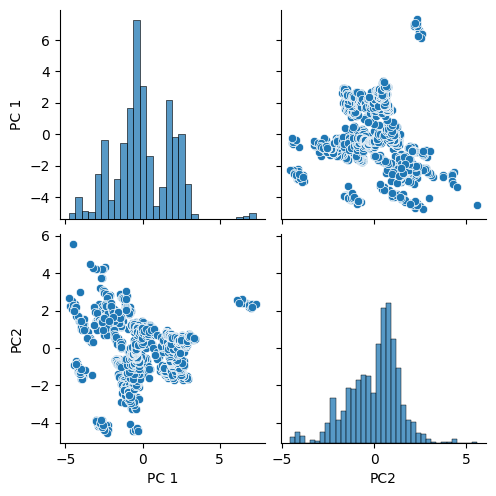

<Figure size 800x800 with 0 Axes>

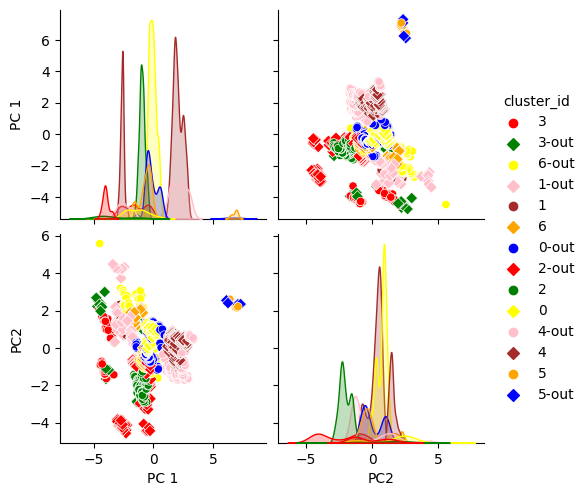

<Figure size 800x800 with 0 Axes>

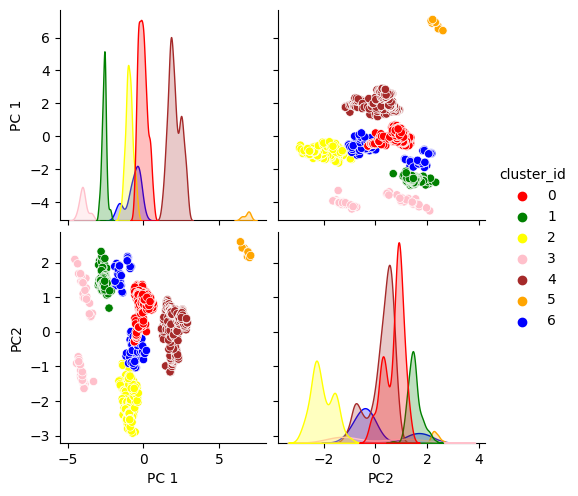

In [15]:
# OPTIMAL VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

# PAIR PLOT OPTIMAL with OUTLIERS
df_pca['cluster_id'] = best_cluster.loc[:, best_cluster.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"], palette=['red', 'green', 'yellow', 'pink', 'brown', 'orange', 'blue'])

#PAIR PLOT OPTIMAL without OUTLIERS
df_pca['cluster_id'] = best_inliers.loc[:, best_inliers.columns.isin(['cluster_id'])]
df_pca.dropna(inplace=True)
df_pca['cluster_id'] = df_pca['cluster_id'].astype(int)

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', palette=['red', 'green', 'yellow', 'pink', 'brown', 'orange', 'blue'])